# Detecting and Clustering Seqlets with Modisco 

In this tutorial, we will explore how to use Modisco within the Decima framework to detect and cluster seqlets—short, high-scoring regions of DNA that are important for model predictions. Modisco (Motif Discovery from Importance Scores) is a powerful tool designed to analyze attribution scores from deep learning models. It identifies recurring patterns, or "motifs," by first locating seqlets—short subsequences with high attribution—and then clustering these seqlets based on similarity. This process helps uncover biologically meaningful sequence motifs that drive the model's predictions, providing insights into regulatory elements and sequence features learned by the model. We will walk through the steps of running Modisco on attribution data, from detecting seqlets to clustering them into motifs, and interpreting the results.


## CLI API

In this tutorial, we'll walk through a practical example of using Decima's CLI API to analyze neuronal cells and uncover how they differ from non-neuronal cells based on the major regulators. Let's first list avaliable cell types: 

In [10]:
! decima query-cell "cell_type.str.contains('neuron') and organ == 'CNS' and disease == 'healthy'"

wandb: Currently logged in as: mhcelik (mhcw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact metadata:latest, 3122.32MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.7 (1842.3MB/s)
	cell_type	tissue	organ	disease	study	dataset	region	subregion	celltype_coarse	n_cells	total_counts	n_genes	size_factor	train_pearson	val_pearson	test_pearson
agg_1112	CGE interneuron	Amygdala_Amygdala	CNS	healthy	jhpce#tran2021	brain_atlas	Amygdala	Amygdala		674	17421456.0	16954	42512.927350555474	0.9454484906394379	0.8549755331049285	0.8667663764982964
agg_1113	CGE interneuron	Amygdala_Basolateral nuclear group (BLN) - lateral nucleus - La	CNS	healthy	SCR_016152	brain_atlas	Amygdala	Basolateral nuclear group (BLN) - lateral nucleus - La		3653	43170604.0	17556	43343.31426365281	0.9556543498602063	0.8580799006688026	0.8653460664237342
agg_1114	CGE interneuron	Amygdala_Bed nucleus of stria terminalis and nearby - BNST	CNS	healthy	SCR_0161

The main arguments for the `decima modisco` CLI command allow you to customize motif discovery for your specific biological question. The `--top-n-markers` argument restricts the analysis to the top N marker genes, focusing on the most distinguishing genes for the selected cell types if not provided all genes are used. The `--max-seqlets` parameter sets an upper limit on the number of seqlets (short, high-scoring regions) extracted per metacluster, which can help manage memory usage and computation time. The `--tss-distance` option defines the window size (in base pairs) around the transcription start site to consider for motif discovery. 

 The `--tasks` argument lets you specify cell types or conditions of interest using a query string, such as `"cell_type.str.contains('neuron') and organ == 'CNS' and disease == 'healthy'"` to select healthy CNS neurons. The `--transform` argument determines how attributions are aggregated or contrasted. For example, `"specificity"` compares the selected tasks (e.g., neurons) against the background (e.g., all other cells), highlighting features specific to the chosen group. Alternatively, `"aggregate"` simply sums attributions across the selected tasks.

The `--batch-size` and `--num-workers` options control parallelization and resource usage during computation. The `--model` argument selects which model replicate or checkpoint to use, and the `-o` or `--output-prefix` sets the path prefix for output files and reports.

In [ ]:
! decima modisco  \
    --top-n-markers 50 \
    --max-seqlets 5000 \
    --tss-distance 5000  \
    --tasks "cell_type.str.contains('neuron') and organ == 'CNS' and disease == 'healthy'" \
    --transform "specificity" \
    --batch-size 1 \
    --model v1_rep0 \
    --num-workers 8 \
    -o example/modisco_neurons

decima - INFO - Using device: cuda
decima - INFO - Loading model and metadata to compute attributions...
wandb: Currently logged in as: mhcelik (mhcw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact metadata:latest, 3122.32MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.7 (1802.9MB/s)
wandb: Downloading large artifact metadata:latest, 3122.32MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.7 (1860.8MB/s)
wandb: Downloading large artifact rep0:latest, 720.03MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.7 (418.6MB/s)
/home/celikm5/Projects/decima/src/decima/interpret/attributer.py:43: UserWarning: `off_tasks` is not provided. Using all other tasks as off_tasks.
Computing attributions...: 100%|████████████████| 50/50 [00:44<00:00,  1.11it/s]
decima - INFO - Loading metadata
wandb: Downloading large artifact metadata:latest, 3122.32MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Don

 The analysis creates the following files:
 - `example/modisco_neurons.h5`: HDF5 file containing the discovered motifs and seqlets generated by modisco.
 - `example/modisco_neurons_patterns.h5`: HDF5 file with processed motif patterns generated by TF-Modisco see TF-modisco API.
 - `example/modisco_neurons_report/`: Directory containing HTML and image reports of discovered motifs.
 - `example/modisco_neurons_seqlets.bed`: BED file with genomic locations of seqlets.
 - `example/modisco_neurons_*.attributions.h5`: HDF5 file containing the raw attribution scores for each input sequence and gene for each replicate. This file is used as input for motif discovery and can be inspected to understand which regions of the genome are most important for model predictions.
 - `example/modisco_neurons_*.attributions.bigwig`: Average attribution scores for each base across all input sequences, stored in BigWig format for visualization in genome browsers.

In [3]:
! ls example/modisco_neurons*

example/modisco_neurons_0.attributions.bigwig
example/modisco_neurons_0.attributions.h5
example/modisco_neurons_0.warnings.qc.log
example/modisco_neurons_1.attributions.bigwig
example/modisco_neurons_1.attributions.h5
example/modisco_neurons_1.warnings.qc.log
example/modisco_neurons.attributions.bigwig
example/modisco_neurons.attributions.h5
example/modisco_neurons.modisco.h5
example/modisco_neurons.seqlets.bed
example/modisco_neurons.warnings.qc.log

example/modisco_neurons_report:
ATF1.H13CORE.1.P.B.png	       REST.H13CORE.0.P.B.png
ATF2.H13CORE.0.PSM.A.png       RXRA.H13CORE.3.P.B.png
ATF2.H13CORE.1.P.B.png	       SATB1.H13CORE.0.P.B.png
ATF3.H13CORE.2.P.B.png	       SNAI2.H13CORE.0.PSM.A.png
ATF4.H13CORE.2.SM.B.png        SP2.H13CORE.1.P.B.png
ATMIN.H13CORE.0.P.B.png        SP3.H13CORE.0.P.B.png
CPEB1.H13CORE.1.S.B.png        SP4.H13CORE.2.P.B.png
CREB1.H13CORE.0.PSM.A.png      SPDEF.H13CORE.1.SM.B.png
CREB5.H13CORE.0.P.B.png        SPI1.H13CORE.0.P.B.png
CREB5.H13CORE.1.SM.B.png  

The following file generates an HTML report with motif visualizations and detailed statistics for each discovered pattern.

In [16]:
from IPython.display import HTML, Image

HTML(filename="example/modisco_neurons_report/motifs.html")

pattern,num_seqlets,modisco_cwm_fwd,modisco_cwm_rev,match0,qval0,match0_logo,match1,qval1,match1_logo,match2,qval2,match2_logo
pos_patterns.pattern_0,79,,,ZN362.H13CORE.0.P.C,2.147410e-02,,Z585A.H13CORE.0.P.C,1.015950e-01,,FOXC1.H13CORE.1.S.C,1.015950e-01,
pos_patterns.pattern_1,75,,,JUN.H13CORE.1.S.C,1.000000e+00,,TF7L1.H13CORE.2.S.C,1.000000e+00,,SPDEF.H13CORE.1.SM.B,1.000000e+00,
pos_patterns.pattern_2,61,,,ZEB2.H13CORE.0.P.B,2.037100e-02,,ITF2.H13CORE.1.PSM.A,2.037100e-02,,SNAI2.H13CORE.0.PSM.A,2.037100e-02,
pos_patterns.pattern_3,58,,,ZNF85.H13CORE.1.P.B,7.257980e-01,,ZN766.H13CORE.0.P.B,7.257980e-01,,ZN250.H13CORE.0.P.C,7.257980e-01,
pos_patterns.pattern_4,56,,,ZN519.H13CORE.0.P.C,3.222360e-01,,ZNF43.H13CORE.0.PSGI.A,3.222360e-01,,FAM200B.H13CORE.0.PSGIB.A,3.222360e-01,
pos_patterns.pattern_5,55,,,KMT2A.H13CORE.0.P.B,2.974570e-01,,ZN519.H13CORE.0.P.C,3.238500e-01,,ZNF66.H13CORE.0.PG.A,6.090510e-01,
pos_patterns.pattern_6,54,,,KMT2A.H13CORE.0.P.B,6.289190e-06,,ZN519.H13CORE.0.P.C,4.988970e-05,,SP2.H13CORE.1.P.B,1.925710e-02,
pos_patterns.pattern_7,54,,,ZEB2.H13CORE.0.P.B,9.978340e-01,,ZEB1.H13CORE.0.P.B,9.978340e-01,,ZN784.H13CORE.0.SM.B,9.978340e-01,
pos_patterns.pattern_8,52,,,SATB1.H13CORE.0.P.B,1.405690e-01,,FOXC2.H13CORE.0.SM.B,2.268190e-01,,CPEB1.H13CORE.1.S.B,3.961930e-01,
pos_patterns.pattern_9,51,,,ATF3.H13CORE.2.P.B,9.799360e-03,,CREB5.H13CORE.1.SM.B,9.799360e-03,,CREB1.H13CORE.0.PSM.A,9.799360e-03,


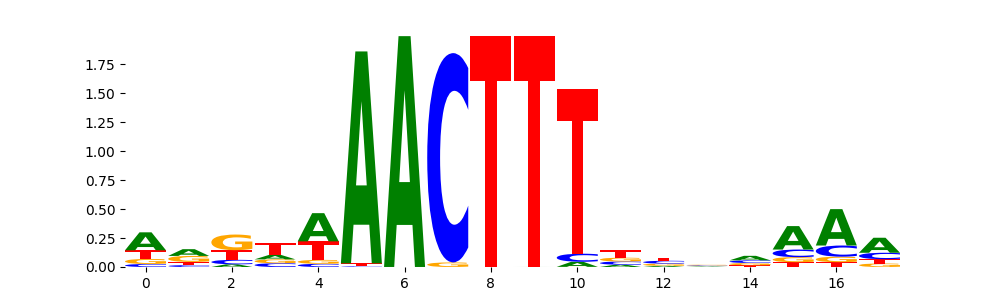

In [18]:
Image(filename="example/modisco_neurons_report/MYT1.H13CORE.0.SG.A.png")

### CLI Subcommands 

The Modisco API provides several subcommands to perform motif discovery and analysis in a stepwise manner.
Here is a detailed explanation of each step:

1. `modisco-attributions`: This subcommand computes attribution scores for each input sequence and gene. You can parallelize this step by running it on multiple GPUs. This is the only step that requires GPUs.

2. `modisco-patterns`: After computing attributions, this subcommand discovers motifs (patterns) by clustering
   the attribution scores using TF-Modisco. See the documentation of Modisco for the details of the output format.

3. `modisco-report`: This subcommand run tomtom to find motif matches for patterns motif images from the discovered patterns.

4. `modisco-seqlet-bed`: This subcommand extracts the genomic locations of seqlets (short, high-scoring
   regions) from the modisco results and writes them to a BED file. This allows for downstream analysis
   or visualization in genome browsers.

By running these subcommands in sequence, you can go from raw model predictions to interpretable motif
discovery, visualization, and downstream analysis.

Let's generate attributions for first replicate:

In [ ]:
! decima modisco-attributions \
    --top-n-markers 50 \
    --tasks "cell_type.str.contains('neuron') and organ == 'CNS' and disease == 'healthy'" \
    --batch-size 1 \
    --model v1_rep0 \
    --num-workers 8 \
    -o example/modisco_subcommands/modisco_neurons_0

decima - INFO - Using device: cuda
decima - INFO - Loading model and metadata to compute attributions...
wandb: Currently logged in as: mhcelik (mhcw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact metadata:latest, 3122.32MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.9 (1684.6MB/s)
wandb: Downloading large artifact metadata:latest, 3122.32MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.7 (1859.3MB/s)
wandb: Downloading large artifact rep0:latest, 720.03MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6 (1204.6MB/s)
/home/celikm5/Projects/decima/src/decima/interpret/attributer.py:43: UserWarning: `off_tasks` is not provided. Using all other tasks as off_tasks.
Computing attributions...: 100%|████████████████| 50/50 [00:44<00:00,  1.11it/s]


end second replicate:

In [4]:
! decima modisco-attributions \
    --top-n-markers 50 \
    --tasks "cell_type.str.contains('neuron') and organ == 'CNS' and disease == 'healthy'" \
    --batch-size 1 \
    --model 1 \
    --num-workers 8 \
    -o example/modisco_subcommands/modisco_neurons_1

decima - INFO - Using device: cuda
decima - INFO - Loading model and metadata to compute attributions...
wandb: Currently logged in as: mhcelik (mhcw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact metadata:latest, 3122.32MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.7 (1831.2MB/s)
wandb: Downloading large artifact metadata:latest, 3122.32MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.7 (1823.6MB/s)
wandb: Downloading large artifact rep1:latest, 720.03MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.7 (417.2MB/s)
/home/celikm5/Projects/decima/src/decima/interpret/attributer.py:43: UserWarning: `off_tasks` is not provided. Using all other tasks as off_tasks.
Computing attributions...: 100%|████████████████| 50/50 [00:45<00:00,  1.11it/s]


In [6]:
! ls example/modisco_subcommands/modisco_neurons*

example/modisco_subcommands/modisco_neurons_0.attributions.bigwig
example/modisco_subcommands/modisco_neurons_0.attributions.h5
example/modisco_subcommands/modisco_neurons_0.warnings.qc.log
example/modisco_subcommands/modisco_neurons_1.attributions.bigwig
example/modisco_subcommands/modisco_neurons_1.attributions.h5
example/modisco_subcommands/modisco_neurons_1.warnings.qc.log
example/modisco_subcommands/modisco_neurons.attributions.bigwig
example/modisco_subcommands/modisco_neurons.attributions.h5
example/modisco_subcommands/modisco_neurons.warnings.qc.log


Next, we will use the generated attributions as input for the pattern discovery step with MoDISco.
The `--attributions` argument expects a comma-separated list of attribution files (one per replicate or model),
which we produced in the previous step. These files contain the importance scores for each base in the input sequences,
and are required for MoDISco to identify recurring patterns (motifs).

In [8]:
! decima modisco-patterns \
    --attributions example/modisco_subcommands/modisco_neurons_0.attributions.h5,example/modisco_subcommands/modisco_neurons_1.attributions.h5 \
    --top-n-markers 50 \
    --max-seqlets 5000 \
    --tss-distance 5000  \
    --tasks "cell_type.str.contains('neuron') and organ == 'CNS' and disease == 'healthy'" \
    --num-workers 8 \
    -o example/modisco_subcommands/modisco_neurons

decima - INFO - Loading metadata
wandb: Currently logged in as: mhcelik (mhcw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact metadata:latest, 3122.32MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.7 (1833.5MB/s)
Loading attributions and sequences...: 100%|████| 50/50 [00:05<00:00,  9.94it/s]
2025-10-06 11:09:35,941 - modisco-lite - INFO - Running TFMoDISco version 2.4.0
2025-10-06 11:09:35,943 - modisco-lite - INFO - Extracting seqlets for 50 tasks:
2025-10-06 11:09:35,944 - modisco-lite - INFO - - Smoothing and splitting tracks
2025-10-06 11:09:35,980 - modisco-lite - INFO - - Computing null values with Laplacian null model
2025-10-06 11:09:36,039 - modisco-lite - INFO - - Computing isotonic thresholds
2025-10-06 11:09:36,060 - modisco-lite - INFO - - Refining thresholds
2025-10-06 11:09:36,361 - modisco-lite - INFO - - Extracting seqlets
2025-10-06 11:09:36,409 - modisco-lite - INFO - - Extracting 1381 positive

This step generates modisco.h5 file with discovered motifs and processed patterns.

In [ ]:
! ls example/modisco_subcommands/modisco_neurons*

In [17]:
! decima modisco-seqlet-bed \
    --modisco-h5 example/modisco_subcommands/modisco_neurons.modisco.h5 \
    -o example/modisco_subcommands/modisco_neurons

wandb: Currently logged in as: mhcelik (mhcw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact metadata:latest, 3122.32MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.7 (1792.1MB/s)
Processing neg_patterns patterns...: 100%|█████| 19/19 [00:00<00:00, 591.46it/s]


Extracting seqlets used in motif detection:

The `.seqlets.bed` file contains the genomic coordinates of all seqlets (short, high-scoring subsequences)
that were used by MoDISco to identify motifs. Each line in the BED file follows
the standard BED format:

  chrom    start    end    name    score    strand

- `chrom`: Chromosome name (e.g., "chr1")
- `start`: 0-based start position of the seqlet
- `end`: End position (not included)
- `name`: Identifier for the seqlet (often includes pattern/cluster info)
- `score`: Score assigned to the seqlet (e.g., importance or cluster assignment)
- `strand`: "+" or "-" indicating the DNA strand
- `core motif start`: The starting position of the core motif within the seqlet, relative to the seqlet's start coordinate.
- `core motif end`: The ending position of the core motif within the seqlet, relative to the seqlet's start coordinate.
- `color`: An optional field indicating the color used to visualize the seqlet or motif in genome browsers.

This file can be loaded in genome browsers or used for downstream analyses to visualize or further process the discovered seqlets.

In [19]:
! head example/modisco_subcommands/modisco_neurons.seqlets.bed

chr1	51514321	51514371	neg_patterns.pattern_3.seqlet_113.EPS15	-0.10036751271172761	-	51514339	51514355	65,105,225
chr1	51514389	51514439	pos_patterns.pattern_1.seqlet_48.EPS15	-0.021704078276343353	-	51514415	51514428	65,105,225
chr1	51514856	51514906	pos_patterns.pattern_4.seqlet_50.EPS15	0.20430506747379695	-	51514858	51514906	65,105,225
chr1	51515007	51515057	pos_patterns.pattern_4.seqlet_36.EPS15	0.11181213204145024	-	51515018	51515066	65,105,225
chr1	51515026	51515076	pos_patterns.pattern_2.seqlet_2.EPS15	-0.39258043596782954	+	51515021	51515067	65,105,225
chr1	51515047	51515097	neg_patterns.pattern_3.seqlet_7.EPS15	-0.5587078251555795	+	51515064	51515080	65,105,225
chr1	51515082	51515132	pos_patterns.pattern_2.seqlet_44.EPS15	0.19132944994089485	-	51515082	51515128	65,105,225
chr1	51515174	51515224	pos_patterns.pattern_4.seqlet_70.EPS15	0.12646874649226447	+	51515175	51515223	65,105,225
chr1	51517345	51517395	pos_patterns.pattern_12.seqlet_38.EPS15	0.08596134528943367	+	51517351

Tomtom is a computational tool from the MEME Suite that compares discovered motifs (such as those output by MoDISco)
to a database of known motifs, identifying statistically significant matches. This helps annotate de novo motifs
by suggesting potential transcription factors or motif families they correspond to.

In the MoDISco workflow, Tomtom is typically run on the discovered motif position weight matrices (PWMs) to
find similar motifs in reference databases (e.g., JASPAR, HOCOMOCO). The output includes a ranked list of
matches for each motif, along with similarity scores and p-values, which can be used to interpret the biological
relevance of the discovered patterns.

Tomtom can be run via the command line or through integrated pipelines, and its results are often included in
MoDISco reports for downstream analysis and visualization.

In [16]:
! decima modisco-reports \
    --modisco-h5 example/modisco_subcommands/modisco_neurons.modisco.h5 \
    -o example/modisco_subcommands/modisco_neurons

Reading patterns for neg_patterns: 100%|██████| 19/19 [00:00<00:00, 3329.93it/s]
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    7.0s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   12.4s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:   13.3s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   16.0s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   16.8s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed

## Python User API

MoDISco can also be run programmatically from Python using the Decima API.
The Python API provides more flexibility and allows you to integrate MoDISco directly into your analysis pipelines.
 
Notably, both the CLI and Python API support the `--off-task` (or `off_tasks` in Python) argument, which enables you to specify a contrasting set of tasks or conditions.
This allows you to perform contrastive motif discovery, identifying patterns that are specific to your target condition (e.g., a particular cell type or tissue)
by comparing against a background or "off" condition. This is useful for highlighting motifs that are enriched or specific to your biological question of interest.

In [3]:
from decima.hub import load_decima_model
from decima.interpret.modisco import modisco


model = load_decima_model("rep0", device=0)  # or 0, 1, 2, 3, "ensemble"

modisco(
    output_prefix="example/modisco_python/modisco_fibroblast",
    tasks="cell_type == 'fibroblast' and organ == 'heart'",
    off_tasks="cell_type == 'fibroblast' and organ != 'heart'",
    top_n_markers=15,
    model=model,
    num_workers=8,
    batch_size=1,
    max_seqlets_per_metacluster=500,
    tss_distance=5000,
)

wandb: Currently logged in as: mhcelik (mhcw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact rep0:latest, 720.03MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.8 (399.4MB/s)
wandb: Downloading large artifact metadata:latest, 3122.32MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.7 (1814.6MB/s)
wandb: Downloading large artifact metadata:latest, 3122.32MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.7 (1851.5MB/s)


  0%|          | 0/2 [00:00<?, ?it/s]

Computing attributions...: 100%|██████████| 15/15 [00:16<00:00,  1.13s/it]
wandb: Downloading large artifact metadata:latest, 3122.32MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.7 (1871.4MB/s)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading attributions and sequences...: 100%|██████████| 15/15 [00:00<00:00, 21.31it/s]
2025-10-06 18:11:34,796 - modisco-lite - INFO - Running TFMoDISco version 2.4.0
2025-10-06 18:11:34,797 - modisco-lite - INFO - Extracting seqlets for 15 tasks:
2025-10-06 18:11:34,798 - modisco-lite - INFO - - Smoothing and splitting tracks
2025-10-06 18:11:34,808 - modisco-lite - INFO - - Computing null values with Laplacian null model
2025-10-06 18:11:34,854 - modisco-lite - INFO - - Computing isotonic thresholds
2025-10-06 18:11:34,863 - modisco-lite - INFO - - Refining thresholds
2025-10-06 18:11:34,943 - modisco-lite - INFO - - Extracting seqlets
2025-10-06 18:11:34,953 - modisco-lite - INFO - - Extracting 384 positive seqlets
2025-10-06 18:11:34,956 - modisco-lite - INFO - - Round 0: Generating coarse resolution affinity matrix for 384 seqlets


  0%|          | 0/384 [00:00<?, ?it/s]

2025-10-06 18:11:47,047 - modisco-lite - INFO - - Round 0: Generating fine resolution affinity matrix for 384 seqlets and 384 neighbors


  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/384 [00:00<?, ?it/s]

2025-10-06 18:11:49,025 - modisco-lite - INFO - - Round 0: Filtering seqlets by correlation
2025-10-06 18:11:49,205 - modisco-lite - INFO - - Round 0: Density adaptation
2025-10-06 18:11:49,648 - modisco-lite - INFO - - Round 0: Clustering with Leiden algorithm


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    6.7s
[Parallel(n_jobs=8)]: Done   2 out of  16 | elapsed:    6.9s remaining:   48.0s
[Parallel(n_jobs=8)]: Done   3 out of  16 | elapsed:    6.9s remaining:   29.9s
[Parallel(n_jobs=8)]: Done   4 out of  16 | elapsed:    7.0s remaining:   21.0s
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    7.1s remaining:   15.6s
[Parallel(n_jobs=8)]: Done   6 out of  16 | elapsed:    7.1s remaining:   11.8s
[Parallel(n_jobs=8)]: Done   7 out of  16 | elapsed:    7.1s remaining:    9.1s
[Parallel(n_jobs=8)]: Done   8 out of  16 | elapsed:    7.1s remaining:    7.1s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    7.2s remaining:    5.6s
[Parallel(n_jobs=8)]: Done  10 out of  16 | elapsed:    7.3s remaining:    4.4s
[Parallel(n_jobs=8)]: Done  11 out of  16 | elapsed:    7.4s remaining:    3.3s
[Parallel(n_jobs=8)]: Done  12 out of  16 | elapsed:    7.5s rem

2025-10-06 18:11:57,387 - modisco-lite - INFO - Leiden clustering quality for seed 0: 0.02360483048930951
2025-10-06 18:11:57,388 - modisco-lite - INFO - Leiden clustering quality for seed 1: 0.02361723253834695
2025-10-06 18:11:57,388 - modisco-lite - INFO - Leiden clustering quality for seed 2: 0.02361364332247759
2025-10-06 18:11:57,388 - modisco-lite - INFO - Leiden clustering quality for seed 3: 0.02360315002202235
2025-10-06 18:11:57,388 - modisco-lite - INFO - Leiden clustering quality for seed 4: 0.023621841682633215
2025-10-06 18:11:57,389 - modisco-lite - INFO - Leiden clustering quality for seed 5: 0.023621841682633215
2025-10-06 18:11:57,389 - modisco-lite - INFO - Leiden clustering quality for seed 6: 0.023613449615038574
2025-10-06 18:11:57,389 - modisco-lite - INFO - Leiden clustering quality for seed 7: 0.02361364332247759
2025-10-06 18:11:57,389 - modisco-lite - INFO - Leiden clustering quality for seed 8: 0.023615291366812573
2025-10-06 18:11:57,390 - modisco-lite - I

[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    7.7s finished


Generating patterns from clusters:: 100%|██████████| 6/6 [00:01<00:00,  3.25it/s]
2025-10-06 18:11:59,240 - modisco-lite - INFO - - Round 1: Generating coarse resolution affinity matrix for 332 seqlets


  0%|          | 0/332 [00:00<?, ?it/s]

2025-10-06 18:11:59,420 - modisco-lite - INFO - - Round 1: Generating fine resolution affinity matrix for 332 seqlets and 332 neighbors


  0%|          | 0/332 [00:00<?, ?it/s]

  0%|          | 0/332 [00:00<?, ?it/s]

2025-10-06 18:12:01,732 - modisco-lite - INFO - - Round 1: Density adaptation
2025-10-06 18:12:02,149 - modisco-lite - INFO - - Round 1: Clustering with Leiden algorithm


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   2 out of  16 | elapsed:    0.4s remaining:    2.8s
[Parallel(n_jobs=8)]: Done   3 out of  16 | elapsed:    0.4s remaining:    1.8s
[Parallel(n_jobs=8)]: Done   4 out of  16 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    0.5s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   6 out of  16 | elapsed:    0.5s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   7 out of  16 | elapsed:    0.6s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   8 out of  16 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    0.7s remaining:    0.6s
[Parallel(n_jobs=8)]: Done  10 out of  16 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=8)]: Done  11 out of  16 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=8)]: Done  12 out of  16 | elapsed:    0.9s rem

2025-10-06 18:12:03,644 - modisco-lite - INFO - Leiden clustering quality for seed 0: 0.026548278897844335
2025-10-06 18:12:03,644 - modisco-lite - INFO - Leiden clustering quality for seed 1: 0.026548278897844335
2025-10-06 18:12:03,645 - modisco-lite - INFO - Leiden clustering quality for seed 2: 0.026520905736640198
2025-10-06 18:12:03,645 - modisco-lite - INFO - Leiden clustering quality for seed 3: 0.026539255688272402
2025-10-06 18:12:03,645 - modisco-lite - INFO - Leiden clustering quality for seed 4: 0.026535249101320407
2025-10-06 18:12:03,645 - modisco-lite - INFO - Leiden clustering quality for seed 5: 0.026528099158945256
2025-10-06 18:12:03,646 - modisco-lite - INFO - Leiden clustering quality for seed 6: 0.026511587839415075
2025-10-06 18:12:03,646 - modisco-lite - INFO - Leiden clustering quality for seed 7: 0.026401092795887534
2025-10-06 18:12:03,646 - modisco-lite - INFO - Leiden clustering quality for seed 8: 0.02656779223573837
2025-10-06 18:12:03,646 - modisco-lite

[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    1.5s finished


Generating patterns from clusters:: 100%|██████████| 6/6 [00:01<00:00,  3.04it/s]
2025-10-06 18:12:05,624 - modisco-lite - INFO - Detecting spurious merging of patterns
Detecting spurious merging of patterns:: 100%|██████████| 6/6 [00:10<00:00,  1.81s/it]
2025-10-06 18:12:17,634 - modisco-lite - INFO - Filtering and merging patterns
Computing subpatterns:: 100%|██████████| 9/9 [00:00<00:00, 51.30it/s]
2025-10-06 18:12:17,813 - modisco-lite - INFO - - Extracting 340 negative seqlets
2025-10-06 18:12:17,816 - modisco-lite - INFO - - Round 0: Generating coarse resolution affinity matrix for 340 seqlets


  0%|          | 0/340 [00:00<?, ?it/s]

2025-10-06 18:12:18,024 - modisco-lite - INFO - - Round 0: Generating fine resolution affinity matrix for 340 seqlets and 340 neighbors


  0%|          | 0/340 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

2025-10-06 18:12:19,624 - modisco-lite - INFO - - Round 0: Filtering seqlets by correlation
2025-10-06 18:12:19,776 - modisco-lite - INFO - - Round 0: Density adaptation
2025-10-06 18:12:20,101 - modisco-lite - INFO - - Round 0: Clustering with Leiden algorithm


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    7.3s
[Parallel(n_jobs=8)]: Done   2 out of  16 | elapsed:    7.3s remaining:   51.4s
[Parallel(n_jobs=8)]: Done   3 out of  16 | elapsed:    7.4s remaining:   32.0s
[Parallel(n_jobs=8)]: Done   4 out of  16 | elapsed:    7.4s remaining:   22.2s
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    7.4s remaining:   16.3s
[Parallel(n_jobs=8)]: Done   6 out of  16 | elapsed:    7.4s remaining:   12.4s
[Parallel(n_jobs=8)]: Done   7 out of  16 | elapsed:    7.5s remaining:    9.6s
[Parallel(n_jobs=8)]: Done   8 out of  16 | elapsed:    7.5s remaining:    7.5s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    7.7s remaining:    6.0s
[Parallel(n_jobs=8)]: Done  10 out of  16 | elapsed:    7.7s remaining:    4.6s
[Parallel(n_jobs=8)]: Done  11 out of  16 | elapsed:    7.7s remaining:    3.5s
[Parallel(n_jobs=8)]: Done  12 out of  16 | elapsed:    7.8s rem

2025-10-06 18:12:28,067 - modisco-lite - INFO - Leiden clustering quality for seed 0: 0.023850872058533996
2025-10-06 18:12:28,067 - modisco-lite - INFO - Leiden clustering quality for seed 1: 0.023768839260606318
2025-10-06 18:12:28,067 - modisco-lite - INFO - Leiden clustering quality for seed 2: 0.02385681078512026
2025-10-06 18:12:28,068 - modisco-lite - INFO - Leiden clustering quality for seed 3: 0.02387438972443567
2025-10-06 18:12:28,068 - modisco-lite - INFO - Leiden clustering quality for seed 4: 0.023876162687244136
2025-10-06 18:12:28,068 - modisco-lite - INFO - Leiden clustering quality for seed 5: 0.02386819542812389
2025-10-06 18:12:28,068 - modisco-lite - INFO - Leiden clustering quality for seed 6: 0.023585021130662808
2025-10-06 18:12:28,069 - modisco-lite - INFO - Leiden clustering quality for seed 7: 0.023854051195930443
2025-10-06 18:12:28,069 - modisco-lite - INFO - Leiden clustering quality for seed 8: 0.023659598169893423
2025-10-06 18:12:28,069 - modisco-lite -

[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    8.0s finished


Generating patterns from clusters:: 100%|██████████| 5/5 [00:00<00:00, 11.39it/s]
2025-10-06 18:12:28,512 - modisco-lite - INFO - - Round 1: Generating coarse resolution affinity matrix for 283 seqlets


  0%|          | 0/283 [00:00<?, ?it/s]

2025-10-06 18:12:28,665 - modisco-lite - INFO - - Round 1: Generating fine resolution affinity matrix for 283 seqlets and 283 neighbors


  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

2025-10-06 18:12:30,404 - modisco-lite - INFO - - Round 1: Density adaptation
2025-10-06 18:12:30,720 - modisco-lite - INFO - - Round 1: Clustering with Leiden algorithm


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of  16 | elapsed:    0.3s remaining:    1.9s
[Parallel(n_jobs=8)]: Done   3 out of  16 | elapsed:    0.3s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   4 out of  16 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   6 out of  16 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   7 out of  16 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   8 out of  16 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=8)]: Done  10 out of  16 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=8)]: Done  11 out of  16 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=8)]: Done  12 out of  16 | elapsed:    0.6s rem

2025-10-06 18:12:31,664 - modisco-lite - INFO - Leiden clustering quality for seed 0: 0.026586659803832666
2025-10-06 18:12:31,664 - modisco-lite - INFO - Leiden clustering quality for seed 1: 0.026586659803832666
2025-10-06 18:12:31,665 - modisco-lite - INFO - Leiden clustering quality for seed 2: 0.02660104643456792
2025-10-06 18:12:31,665 - modisco-lite - INFO - Leiden clustering quality for seed 3: 0.026634521581033865
2025-10-06 18:12:31,665 - modisco-lite - INFO - Leiden clustering quality for seed 4: 0.026616418993762592
2025-10-06 18:12:31,665 - modisco-lite - INFO - Leiden clustering quality for seed 5: 0.026392340322682274
2025-10-06 18:12:31,666 - modisco-lite - INFO - Leiden clustering quality for seed 6: 0.026586659803832666
2025-10-06 18:12:31,666 - modisco-lite - INFO - Leiden clustering quality for seed 7: 0.026603553780386605
2025-10-06 18:12:31,667 - modisco-lite - INFO - Leiden clustering quality for seed 8: 0.02660251974475603
2025-10-06 18:12:31,667 - modisco-lite 

[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.9s finished


Generating patterns from clusters:: 100%|██████████| 5/5 [00:00<00:00,  7.64it/s]
2025-10-06 18:12:32,325 - modisco-lite - INFO - Detecting spurious merging of patterns
Detecting spurious merging of patterns:: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]
2025-10-06 18:12:41,110 - modisco-lite - INFO - Filtering and merging patterns
Reading patterns for neg_patterns: 100%|██████████| 5/5 [00:00<00:00, 3024.01it/s]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    8.2s
[Parallel(n_jobs=8)]: Done   2 out of  14 | elapsed:   13.3s remaining:  1.3min
[Parallel(n_jobs=8)]: Done   3 out of  14 | elapsed:   14.1s remaining:   51.5s
[Parallel(n_jobs=8)]: Done   4 out of  14 | elapsed:   14.4s remaining:   35.9s
[Parallel(n_jobs=8)]: Done   5 out of  14 | elapsed:   15.6s remaining:   28.0s
[Parallel(n_jobs=8)]: Done   6 out of  14 | elapsed:   42.0s remaining:   56.0s
[Parallel(n_jobs=8)]: Done   7 out of  14 | elapsed:   52.6s remaining:   52.6s
[Parallel(n_jobs=8)]: Done   8 out of  14 | elapsed:  1.1min remaining:   50.0s
[Parallel(n_jobs=8)]: Done   9 out of  14 | elapsed:  1.4min remaining:   45.6s
[Parallel(n_jobs=8)]: Done  10 out of  14 | elapsed:  1.4min remaining:   33.1s
[Parallel(n_jobs=8)]: Done  11 out of  14 | elapsed:  1.4min remaining:   22.6s
[Parallel(n_jobs=8)]: Done  12 out of  14 | elapsed:  1.4min rem

wandb: Downloading large artifact metadata:latest, 3122.32MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.7 (1849.3MB/s)
Processing neg_patterns patterns...: 100%|██████████| 5/5 [00:00<00:00, 621.42it/s]


The function above consists of the following functions:

In [4]:
from decima.interpret.modisco import (
    predict_save_modisco_attributions,
    modisco_patterns,
    modisco_reports,
    modisco_seqlet_bed,
)

`predict_save_modisco_attributions` computes and saves attributions for the specified tasks and model.

In [5]:
predict_save_modisco_attributions(
    output_prefix="example/modisco_python_subcommands/modisco_fibroblast_0",
    tasks="cell_type == 'fibroblast' and organ == 'heart'",
    off_tasks="cell_type == 'fibroblast' and organ != 'heart'",
    top_n_markers=15,
    model=model,
    batch_size=1,
)

wandb: Downloading large artifact metadata:latest, 3122.32MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.6 (1894.8MB/s)
wandb: Downloading large artifact metadata:latest, 3122.32MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.8 (1742.1MB/s)


  0%|          | 0/2 [00:00<?, ?it/s]

Computing attributions...: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Lets run it for the second replicate:

In [6]:
predict_save_modisco_attributions(
    output_prefix="example/modisco_python_subcommands/modisco_fibroblast_1",
    tasks="cell_type == 'fibroblast' and organ == 'heart'",
    off_tasks="cell_type == 'fibroblast' and organ != 'heart'",
    top_n_markers=15,
    model=1,
    batch_size=1,
)

wandb: Downloading large artifact metadata:latest, 3122.32MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.7 (1835.3MB/s)
wandb: Downloading large artifact metadata:latest, 3122.32MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.8 (1744.2MB/s)
wandb: Downloading large artifact rep1:latest, 720.03MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5 (1415.1MB/s)


  0%|          | 0/2 [00:00<?, ?it/s]

Computing attributions...: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


`AttributionResult` allows you to load and work with attribution results saved in HDF5 format.
It provides convenient access to gene names, sequences, and attributions for downstream analysis.
`agg_func` specifies how to aggregate attributions across multiple replicates or samples (e.g., 'mean', 'sum' or None) If None, attributions are not aggregated but retuned as new dimension.
`num_workers` sets the number of parallel worker processes to use for loading and processing data, which can speed up computation.
`correct_grad` determines whether to apply gradient correction to the attributions, which can improve interpretability in some cases.

In [7]:
from decima.interpret.attributions import AttributionResult

with AttributionResult(
    [
        "example/modisco_python_subcommands/modisco_fibroblast_0.attributions.h5",
        "example/modisco_python_subcommands/modisco_fibroblast_1.attributions.h5",
    ],
    correct_grad=False,
    num_workers=8,
    agg_func="mean",
) as ar:
    genes = ar.genes
    print("Genes: ", genes)

    seqs, attrs = ar.load(genes[:5])
    print("Seqs: ", seqs)
    print("Attrs: ", attrs)

Genes:  ['ANKRD1', 'CASQ2', 'TBX20', 'MYOZ2', 'HSPB3', 'PLN', 'NPPA', 'SMCO1', 'POPDC2', 'TNNI3', 'MYL7', 'ASB11', 'RBM24', 'NPPB', 'MIR133A1HG']


Loading attributions and sequences...: 100%|██████████| 5/5 [00:00<00:00,  7.59it/s]


Seqs:  [[[1. 1. 1. ... 1. 0. 0.]
  [0. 0. 0. ... 0. 1. 1.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 1. 0. 0.]
  [0. 1. 1. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 1. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 1. 0. ... 1. 0. 1.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 1.]
  [0. 1. 0. ... 1. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 1. ... 0. 1. 0.]]

 [[0. 0. 0. ... 1. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 1.]
  [1. 0. 0. ... 0. 1. 0.]]]
Attrs:  [[[ 3.76145852e-06  3.03478555e-06  7.44035424e-06 ... -6.63653460e-04
    4.05797458e-04  3.16523459e-04]
  [ 7.55026849e-06  1.63838381e-05 -2.46401214e-06 ...  1.20408889e-03
   -5.13944813e-04 -1.87091660e-04]
  [-3.95166535e-06  2.12123268e-07 -1.75476748e-05 ... -3.38858253e-04
   -3.90247933e-05  1.54834273e-04]
  [ 1.02410469e-05  7.77581295e-06  4.79289201e-06 ...  2.04334607e-04
    4.03160076e-04  2.12350627e-04]]

 [[-6.97570385e-07 -8.625

`modisco_patterns` runs modisco and cluster seqlets into patterns:

In [8]:
modisco_patterns(
    output_prefix="example/modisco_python_subcommands/modisco_fibroblast",
    attributions=[
        "example/modisco_python_subcommands/modisco_fibroblast_0.attributions.h5",
        "example/modisco_python_subcommands/modisco_fibroblast_1.attributions.h5",
    ],
    tasks="cell_type == 'fibroblast' and organ == 'heart'",
    off_tasks="cell_type == 'fibroblast' and organ != 'heart'",
    top_n_markers=15,
    num_workers=8,
    max_seqlets_per_metacluster=500,
    tss_distance=5000,
)

wandb: Downloading large artifact metadata:latest, 3122.32MB. 1 files... 


wandb:   1 of 1 files downloaded.  
Done. 0:0:1.8 (1769.2MB/s)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading attributions and sequences...: 100%|██████████| 15/15 [00:01<00:00, 10.76it/s]
2025-10-06 18:16:03,703 - modisco-lite - INFO - Running TFMoDISco version 2.4.0
2025-10-06 18:16:03,703 - modisco-lite - INFO - Running TFMoDISco version 2.4.0
2025-10-06 18:16:03,704 - modisco-lite - INFO - Extracting seqlets for 15 tasks:
2025-10-06 18:16:03,704 - modisco-lite - INFO - Extracting seqlets for 15 tasks:
2025-10-06 18:16:03,705 - modisco-lite - INFO - - Smoothing and splitting tracks
2025-10-06 18:16:03,705 - modisco-lite - INFO - - Smoothing and splitting tracks
2025-10-06 18:16:03,716 - modisco-lite - INFO - - Computing null values with Laplacian null model
2025-10-06 18:16:03,716 - modisco-lite - INFO - - Computing null values with Laplacian null model
2025-10-06 18:16:03,762 - modisco-lite - INFO - - Computing isotonic thresholds
2025-10-06 18:16:03,762 - modisco-lite - INFO - - Computing isotonic thresholds
2025-10-06 18:16:03,771 - modisco-lite - INFO - - Refining thresholds
202

  0%|          | 0/454 [00:00<?, ?it/s]

2025-10-06 18:16:04,194 - modisco-lite - INFO - - Round 0: Generating fine resolution affinity matrix for 454 seqlets and 454 neighbors
2025-10-06 18:16:04,194 - modisco-lite - INFO - - Round 0: Generating fine resolution affinity matrix for 454 seqlets and 454 neighbors


  0%|          | 0/454 [00:00<?, ?it/s]

  0%|          | 0/454 [00:00<?, ?it/s]

2025-10-06 18:16:06,868 - modisco-lite - INFO - - Round 0: Filtering seqlets by correlation
2025-10-06 18:16:06,868 - modisco-lite - INFO - - Round 0: Filtering seqlets by correlation
2025-10-06 18:16:07,102 - modisco-lite - INFO - - Round 0: Density adaptation
2025-10-06 18:16:07,102 - modisco-lite - INFO - - Round 0: Density adaptation
2025-10-06 18:16:07,782 - modisco-lite - INFO - - Round 0: Clustering with Leiden algorithm
2025-10-06 18:16:07,782 - modisco-lite - INFO - - Round 0: Clustering with Leiden algorithm


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:   12.2s
[Parallel(n_jobs=8)]: Done   2 out of  16 | elapsed:   12.2s remaining:  1.4min
[Parallel(n_jobs=8)]: Done   3 out of  16 | elapsed:   12.2s remaining:   52.8s
[Parallel(n_jobs=8)]: Done   4 out of  16 | elapsed:   12.3s remaining:   36.8s
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:   12.3s remaining:   27.2s
[Parallel(n_jobs=8)]: Done   6 out of  16 | elapsed:   12.4s remaining:   20.7s
[Parallel(n_jobs=8)]: Done   7 out of  16 | elapsed:   12.4s remaining:   16.0s
[Parallel(n_jobs=8)]: Done   8 out of  16 | elapsed:   12.5s remaining:   12.5s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:   12.8s remaining:   10.0s
[Parallel(n_jobs=8)]: Done  10 out of  16 | elapsed:   13.0s remaining:    7.8s
[Parallel(n_jobs=8)]: Done  11 out of  16 | elapsed:   13.1s remaining:    6.0s
[Parallel(n_jobs=8)]: Done  12 out of  16 | elapsed:   13.2s rem

2025-10-06 18:16:21,397 - modisco-lite - INFO - Leiden clustering quality for seed 0: 0.02092204286706559
2025-10-06 18:16:21,397 - modisco-lite - INFO - Leiden clustering quality for seed 0: 0.02092204286706559
2025-10-06 18:16:21,398 - modisco-lite - INFO - Leiden clustering quality for seed 1: 0.020929666377409343
2025-10-06 18:16:21,398 - modisco-lite - INFO - Leiden clustering quality for seed 1: 0.020929666377409343
2025-10-06 18:16:21,398 - modisco-lite - INFO - Leiden clustering quality for seed 2: 0.020363825585150153
2025-10-06 18:16:21,398 - modisco-lite - INFO - Leiden clustering quality for seed 2: 0.020363825585150153
2025-10-06 18:16:21,398 - modisco-lite - INFO - Leiden clustering quality for seed 3: 0.020905953578916604
2025-10-06 18:16:21,398 - modisco-lite - INFO - Leiden clustering quality for seed 3: 0.020905953578916604
2025-10-06 18:16:21,399 - modisco-lite - INFO - Leiden clustering quality for seed 4: 0.020790482063174655
2025-10-06 18:16:21,399 - modisco-lite 

  0%|          | 0/407 [00:00<?, ?it/s]

2025-10-06 18:16:23,788 - modisco-lite - INFO - - Round 1: Generating fine resolution affinity matrix for 407 seqlets and 407 neighbors
2025-10-06 18:16:23,788 - modisco-lite - INFO - - Round 1: Generating fine resolution affinity matrix for 407 seqlets and 407 neighbors


  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

2025-10-06 18:16:27,265 - modisco-lite - INFO - - Round 1: Density adaptation
2025-10-06 18:16:27,265 - modisco-lite - INFO - - Round 1: Density adaptation
2025-10-06 18:16:27,911 - modisco-lite - INFO - - Round 1: Clustering with Leiden algorithm
2025-10-06 18:16:27,911 - modisco-lite - INFO - - Round 1: Clustering with Leiden algorithm


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done   2 out of  16 | elapsed:    0.6s remaining:    3.9s
[Parallel(n_jobs=8)]: Done   3 out of  16 | elapsed:    0.6s remaining:    2.8s
[Parallel(n_jobs=8)]: Done   4 out of  16 | elapsed:    0.7s remaining:    2.1s
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    0.7s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   6 out of  16 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   7 out of  16 | elapsed:    0.8s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   8 out of  16 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    1.2s remaining:    0.9s
[Parallel(n_jobs=8)]: Done  10 out of  16 | elapsed:    1.2s remaining:    0.7s
[Parallel(n_jobs=8)]: Done  11 out of  16 | elapsed:    1.4s remaining:    0.6s
[Parallel(n_jobs=8)]: Done  12 out of  16 | elapsed:    1.6s rem

2025-10-06 18:16:29,979 - modisco-lite - INFO - Leiden clustering quality for seed 0: 0.025002069983353303
2025-10-06 18:16:29,979 - modisco-lite - INFO - Leiden clustering quality for seed 0: 0.025002069983353303
2025-10-06 18:16:29,980 - modisco-lite - INFO - Leiden clustering quality for seed 1: 0.02508670994886661
2025-10-06 18:16:29,980 - modisco-lite - INFO - Leiden clustering quality for seed 1: 0.02508670994886661
2025-10-06 18:16:29,981 - modisco-lite - INFO - Leiden clustering quality for seed 2: 0.024970708770517408
2025-10-06 18:16:29,981 - modisco-lite - INFO - Leiden clustering quality for seed 2: 0.024970708770517408
2025-10-06 18:16:29,981 - modisco-lite - INFO - Leiden clustering quality for seed 3: 0.02513240247110472
2025-10-06 18:16:29,981 - modisco-lite - INFO - Leiden clustering quality for seed 3: 0.02513240247110472
2025-10-06 18:16:29,982 - modisco-lite - INFO - Leiden clustering quality for seed 4: 0.02514310327023221
2025-10-06 18:16:29,982 - modisco-lite - I

[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    2.0s finished


Generating patterns from clusters:: 100%|██████████| 6/6 [00:02<00:00,  2.59it/s]
2025-10-06 18:16:32,307 - modisco-lite - INFO - Detecting spurious merging of patterns
2025-10-06 18:16:32,307 - modisco-lite - INFO - Detecting spurious merging of patterns
Detecting spurious merging of patterns:: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]
2025-10-06 18:16:41,865 - modisco-lite - INFO - Filtering and merging patterns
2025-10-06 18:16:41,865 - modisco-lite - INFO - Filtering and merging patterns
Computing subpatterns:: 100%|██████████| 9/9 [00:00<00:00, 38.31it/s]
2025-10-06 18:16:42,104 - modisco-lite - INFO - - Extracting 329 negative seqlets
2025-10-06 18:16:42,104 - modisco-lite - INFO - - Extracting 329 negative seqlets
2025-10-06 18:16:42,107 - modisco-lite - INFO - - Round 0: Generating coarse resolution affinity matrix for 329 seqlets
2025-10-06 18:16:42,107 - modisco-lite - INFO - - Round 0: Generating coarse resolution affinity matrix for 329 seqlets


  0%|          | 0/329 [00:00<?, ?it/s]

2025-10-06 18:16:42,352 - modisco-lite - INFO - - Round 0: Generating fine resolution affinity matrix for 329 seqlets and 329 neighbors
2025-10-06 18:16:42,352 - modisco-lite - INFO - - Round 0: Generating fine resolution affinity matrix for 329 seqlets and 329 neighbors


  0%|          | 0/329 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

2025-10-06 18:16:43,824 - modisco-lite - INFO - - Round 0: Filtering seqlets by correlation
2025-10-06 18:16:43,824 - modisco-lite - INFO - - Round 0: Filtering seqlets by correlation
2025-10-06 18:16:43,971 - modisco-lite - INFO - - Round 0: Density adaptation
2025-10-06 18:16:43,971 - modisco-lite - INFO - - Round 0: Density adaptation
2025-10-06 18:16:44,298 - modisco-lite - INFO - - Round 0: Clustering with Leiden algorithm
2025-10-06 18:16:44,298 - modisco-lite - INFO - - Round 0: Clustering with Leiden algorithm


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    7.2s
[Parallel(n_jobs=8)]: Done   2 out of  16 | elapsed:    7.4s remaining:   51.5s
[Parallel(n_jobs=8)]: Done   3 out of  16 | elapsed:    7.4s remaining:   32.2s
[Parallel(n_jobs=8)]: Done   4 out of  16 | elapsed:    7.5s remaining:   22.6s
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    7.6s remaining:   16.7s
[Parallel(n_jobs=8)]: Done   6 out of  16 | elapsed:    7.6s remaining:   12.6s
[Parallel(n_jobs=8)]: Done   7 out of  16 | elapsed:    7.6s remaining:    9.8s
[Parallel(n_jobs=8)]: Done   8 out of  16 | elapsed:    7.6s remaining:    7.6s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    7.7s remaining:    6.0s
[Parallel(n_jobs=8)]: Done  10 out of  16 | elapsed:    7.9s remaining:    4.7s
[Parallel(n_jobs=8)]: Done  11 out of  16 | elapsed:    7.9s remaining:    3.6s
[Parallel(n_jobs=8)]: Done  12 out of  16 | elapsed:    8.0s rem

2025-10-06 18:16:52,494 - modisco-lite - INFO - Leiden clustering quality for seed 0: 0.026763578635124848
2025-10-06 18:16:52,494 - modisco-lite - INFO - Leiden clustering quality for seed 0: 0.026763578635124848
2025-10-06 18:16:52,495 - modisco-lite - INFO - Leiden clustering quality for seed 1: 0.0265094500699511
2025-10-06 18:16:52,495 - modisco-lite - INFO - Leiden clustering quality for seed 1: 0.0265094500699511
2025-10-06 18:16:52,496 - modisco-lite - INFO - Leiden clustering quality for seed 2: 0.02654428903412237
2025-10-06 18:16:52,496 - modisco-lite - INFO - Leiden clustering quality for seed 2: 0.02654428903412237
2025-10-06 18:16:52,496 - modisco-lite - INFO - Leiden clustering quality for seed 3: 0.026721538949614872
2025-10-06 18:16:52,496 - modisco-lite - INFO - Leiden clustering quality for seed 3: 0.026721538949614872
2025-10-06 18:16:52,497 - modisco-lite - INFO - Leiden clustering quality for seed 4: 0.026735509288973492
2025-10-06 18:16:52,497 - modisco-lite - IN

[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    8.2s finished


Generating patterns from clusters:: 100%|██████████| 6/6 [00:01<00:00,  4.27it/s]
2025-10-06 18:16:53,909 - modisco-lite - INFO - - Round 1: Generating coarse resolution affinity matrix for 232 seqlets
2025-10-06 18:16:53,909 - modisco-lite - INFO - - Round 1: Generating coarse resolution affinity matrix for 232 seqlets


  0%|          | 0/232 [00:00<?, ?it/s]

2025-10-06 18:16:54,025 - modisco-lite - INFO - - Round 1: Generating fine resolution affinity matrix for 232 seqlets and 232 neighbors
2025-10-06 18:16:54,025 - modisco-lite - INFO - - Round 1: Generating fine resolution affinity matrix for 232 seqlets and 232 neighbors


  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/232 [00:00<?, ?it/s]

2025-10-06 18:16:55,143 - modisco-lite - INFO - - Round 1: Density adaptation
2025-10-06 18:16:55,143 - modisco-lite - INFO - - Round 1: Density adaptation
2025-10-06 18:16:55,363 - modisco-lite - INFO - - Round 1: Clustering with Leiden algorithm
2025-10-06 18:16:55,363 - modisco-lite - INFO - - Round 1: Clustering with Leiden algorithm


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Batch computation too fast (0.19564294815063477s.) Setting batch_size=2.
[Parallel(n_jobs=8)]: Done   2 out of  16 | elapsed:    0.2s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   3 out of  16 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   4 out of  16 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of  16 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   7 out of  16 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   8 out of  16 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    0.4s remaining:    0.3s


2025-10-06 18:16:55,864 - modisco-lite - INFO - Leiden clustering quality for seed 0: 0.036596707967135385
2025-10-06 18:16:55,864 - modisco-lite - INFO - Leiden clustering quality for seed 0: 0.036596707967135385
2025-10-06 18:16:55,865 - modisco-lite - INFO - Leiden clustering quality for seed 1: 0.036607288086638164
2025-10-06 18:16:55,865 - modisco-lite - INFO - Leiden clustering quality for seed 1: 0.036607288086638164
2025-10-06 18:16:55,866 - modisco-lite - INFO - Leiden clustering quality for seed 2: 0.03657606307660279
2025-10-06 18:16:55,866 - modisco-lite - INFO - Leiden clustering quality for seed 2: 0.03657606307660279
2025-10-06 18:16:55,866 - modisco-lite - INFO - Leiden clustering quality for seed 3: 0.03660305121676245
2025-10-06 18:16:55,866 - modisco-lite - INFO - Leiden clustering quality for seed 3: 0.03660305121676245
2025-10-06 18:16:55,867 - modisco-lite - INFO - Leiden clustering quality for seed 4: 0.036607288086638164
2025-10-06 18:16:55,867 - modisco-lite - 

[Parallel(n_jobs=8)]: Done  10 out of  16 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  11 out of  16 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  12 out of  16 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  14 out of  16 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    0.5s finished


Generating patterns from clusters:: 100%|██████████| 6/6 [00:00<00:00,  6.97it/s]
2025-10-06 18:16:56,737 - modisco-lite - INFO - Detecting spurious merging of patterns
2025-10-06 18:16:56,737 - modisco-lite - INFO - Detecting spurious merging of patterns
Detecting spurious merging of patterns:: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]
2025-10-06 18:17:05,761 - modisco-lite - INFO - Filtering and merging patterns
2025-10-06 18:17:05,761 - modisco-lite - INFO - Filtering and merging patterns
Computing subpatterns:: 100%|██████████| 6/6 [00:00<00:00, 51.68it/s]


`modisco_reports` runs tomtom and annotated patterns with now motifs.

In [9]:
modisco_reports(
    output_prefix="example/modisco_python_subcommands/modisco_fibroblast",
    modisco_h5="example/modisco_python_subcommands/modisco_fibroblast.modisco.h5",
    num_workers=8,
)

Reading patterns for neg_patterns: 100%|██████████| 6/6 [00:00<00:00, 2932.74it/s]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    8.0s
[Parallel(n_jobs=8)]: Done   2 out of  15 | elapsed:   15.0s remaining:  1.6min
[Parallel(n_jobs=8)]: Done   3 out of  15 | elapsed:   15.7s remaining:  1.0min
[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:  1.0min remaining:  2.8min
[Parallel(n_jobs=8)]: Done   5 out of  15 | elapsed:  1.2min remaining:  2.4min
[Parallel(n_jobs=8)]: Done   6 out of  15 | elapsed:  1.2min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   7 out of  15 | elapsed:  1.3min remaining:  1.5min
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:  1.4min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   9 out of  15 | elapsed:  1.4min remaining:   55.7s
[Parallel(n_jobs=8)]: Done  10 out of  15 | elapsed:  1.4min remaining:   42.0s
[Parallel(n_jobs=8)]: Done  11 out of  15 | elapsed:  1.5min remaining:   33.4s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:  1.9min rem

Seqlet bed extract seqlets from modisco output:

In [10]:
modisco_seqlet_bed(
    output_prefix="example/modisco_python_subcommands/modisco_fibroblast",
    modisco_h5="example/modisco_python_subcommands/modisco_fibroblast.modisco.h5",
)

wandb: Downloading large artifact metadata:latest, 3122.32MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.7 (1840.6MB/s)
Processing neg_patterns patterns...: 100%|██████████| 6/6 [00:00<00:00, 599.99it/s]
